In [1]:
using LinearAlgebra
using Random: seed!
using Plots; default(markerstrokecolor=nothing) 
using LaTeXStrings
using Distributions:Poisson
using Statistics: mean
using Random: seed!
include("poisson_admm_b0.jl")
include("poisson_admm_bn0.jl")
include("Wirtinger_flow.jl")
include("Gerchberg_saxton.jl")
include("LSMM.jl")
avg_count = 2
var = 1
# seed!(2333)
N = 100
M_list = [1000, 2000, 3000, 4000, 5000, 6000]
r_time = 3
niter = 250

250

In [2]:
"""
Should do a warm up.
"""
xtrue = cumsum(mod.(1:N, 30) .== 0);
x0_rand = randn(N)
M = 3000
A = sqrt(var/2) * (randn(M, N) + im * randn(M, N)) # Each iteration, A is different.
b = ones(M)
cons = avg_count / mean(abs2.(A * xtrue))
A = sqrt(cons) * A # scale matrix A
#     print("Average counts after scaling: ", mean(abs2.(A * xtrue)))
y_true = abs2.(A * xtrue) + b
y_pos = rand.(Poisson.(y_true)); # poisson noise
        
phi = (v, yi, bi) -> (abs2(v) + bi) - yi * log(abs2(v) + bi) # (v^2 + b) - yi * log(v^2 + b)
cost_func = (x,iter) -> [sum(phi.(A * x, y_pos, b)), time()]

xout_wf_gau, cout_wf_gau = Wirtinger_flow(A,y_pos,b; gradhow = :gaussian, xhow = :real, x0 = x0_rand, niter = niter, fun = cost_func)
xout_wf_pois, cout_wf_pois = Wirtinger_flow(A,y_pos,b; gradhow = :poisson, xhow = :real, x0 = x0_rand, niter = niter, fun = cost_func)
xout_gs, cout_gs = Gerchberg_saxton(A,y_pos,b; xhow = :real, x0 = x0_rand, niter = niter, fun = cost_func)
xout_lsmm_max, cout_lsmm_max = LSMM(A,y_pos,b; curvhow = :max, xhow = :real, x0 = x0_rand, niter = niter, fun = cost_func)
xout_lsmm_imp, cout_lsmm_imp = LSMM(A,y_pos,b; curvhow = :imp, xhow = :real, x0 = x0_rand, niter = niter, fun = cost_func)
xout_admm_cons, cout_admm_cons = poisson_admm_bn0(A,y_pos,b; phow =:constant, xhow = :real, x0 = x0_rand, ρ = 4, niter = niter, fun = cost_func)
xout_admm_adap, cout_admm_adap = poisson_admm_bn0(A,y_pos,b; phow =:adaptive, xhow = :real, x0 = x0_rand, ρ = 4, niter = niter, fun = cost_func);

lf = x -> log10(max(x,1e-16))
grab = (o,i) -> hcat(o...)[i,:]
lg = (o,i) -> lf.(grab(o,i))

cost_wf_gau = grab(cout_wf_gau, 1)
time_wf_gau = grab(cout_wf_gau, 2) .- cout_wf_gau[1][2]

cost_wf_pois = grab(cout_wf_pois, 1)
time_wf_pois = grab(cout_wf_pois, 2) .- cout_wf_pois[1][2]

cost_gs = grab(cout_gs, 1)
time_gs = grab(cout_gs, 2) .- cout_gs[1][2]

cost_lsmm_max = grab(cout_lsmm_max, 1)
time_lsmm_max = grab(cout_lsmm_max, 2) .- cout_lsmm_max[1][2]

cost_lsmm_imp = grab(cout_lsmm_imp, 1)
time_lsmm_imp = grab(cout_lsmm_imp, 2) .- cout_lsmm_imp[1][2]

cost_admm_cons = grab(cout_admm_cons, 1)
time_admm_cons = grab(cout_admm_cons, 2) .- cout_admm_cons[1][2]

cost_admm_adap = grab(cout_admm_adap, 1)
time_admm_adap = grab(cout_admm_adap, 2) .- cout_admm_adap[1][2];




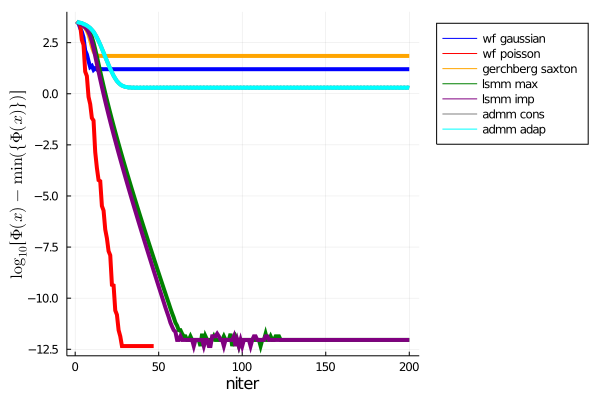

In [3]:
min_cost = minimum([cost_wf_gau; cost_wf_pois; cost_gs; cost_lsmm_max; cost_lsmm_imp; cost_admm_cons; cost_admm_adap])
plot(log10.(cost_wf_gau[1:niter-50] .- min_cost), color=:blue, linewidth = 4, legend=:outertopright, label = "wf gaussian", xlabel = "niter", ylabel = L"\log_{10} [ \Phi(x)-\min(\{\Phi(x)\}) ] ")
plot!(log10.(cost_wf_pois[1:niter-50] .- min_cost), color=:red, linewidth = 4, label = "wf poisson")
plot!(log10.(cost_gs[1:niter-50] .- min_cost), color=:orange, linewidth = 4, label = "gerchberg saxton")
plot!(log10.(cost_lsmm_max[1:niter-50] .- min_cost), color=:green, linewidth = 4, label = "lsmm max")
plot!(log10.(cost_lsmm_imp[1:niter-50] .- min_cost), color=:purple, linewidth = 4, label = "lsmm imp")
plot!(log10.(cost_admm_cons[1:niter-50] .- min_cost), color=:gray, linewidth = 4, label = "admm cons")
plot!(log10.(cost_admm_adap[1:niter-50] .- min_cost), color=:cyan, linewidth = 4, label = "admm adap")


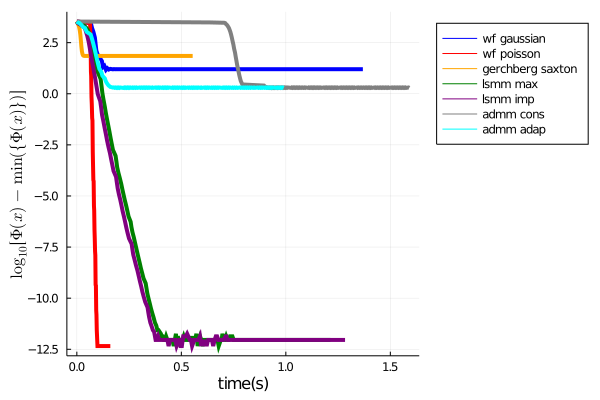

In [4]:

min_cost = minimum([cost_wf_gau; cost_wf_pois; cost_gs; cost_lsmm_max; cost_lsmm_imp; cost_admm_cons; cost_admm_adap])
plot(time_wf_gau[1:niter-50], log10.(cost_wf_gau[1:niter-50] .- min_cost), color=:blue, linewidth = 4, legend=:outertopright, label = "wf gaussian", xlabel = "time(s)", ylabel = L"\log_{10} [ \Phi(x)-\min(\{\Phi(x)\}) ] ")
plot!(time_wf_pois[1:niter-50], log10.(cost_wf_pois[1:niter-50] .- min_cost), color=:red, linewidth = 4, label = "wf poisson")
plot!(time_gs[1:niter-50], log10.(cost_gs[1:niter-50] .- min_cost), color=:orange, linewidth = 4, label = "gerchberg saxton")
plot!(time_lsmm_max[1:niter-50], log10.(cost_lsmm_max[1:niter-50] .- min_cost), color=:green, linewidth = 4, label = "lsmm max")
plot!(time_lsmm_imp[1:niter-50], log10.(cost_lsmm_imp[1:niter-50] .- min_cost), color=:purple, linewidth = 4, label = "lsmm imp")
plot!(time_admm_cons[1:niter-50], log10.(cost_admm_cons[1:niter-50] .- min_cost), color=:gray, linewidth = 4, label = "admm cons")
plot!(time_admm_adap[1:niter-50], log10.(cost_admm_adap[1:niter-50] .- min_cost), color=:cyan, linewidth = 4, label = "admm adap")



In [5]:
xtrue = cumsum(mod.(1:N, 30) .== 0);

nrmse_xout_wf_gau = zeros(r_time, length(M_list))
nrmse_xout_wf_pois = zeros(r_time, length(M_list))
nrmse_xout_gs = zeros(r_time, length(M_list))
nrmse_xout_lsmm_max = zeros(r_time, length(M_list))
nrmse_xout_lsmm_imp = zeros(r_time, length(M_list))
nrmse_xout_admm_cons = zeros(r_time, length(M_list))
nrmse_xout_admm_adap = zeros(r_time, length(M_list))


# over sample case
for j = 1:length(M_list)
    M = M_list[j]
    b = 1 * ones(M) # background counts
    for r = 1:r_time
        # Initialize by random vectors
        x0_rand = randn(N)
        A = sqrt(var/2) * (randn(M, N) + im * randn(M, N)) # Each iteration, A is different.
        cons = avg_count / mean(abs2.(A * xtrue))
        A = sqrt(cons) * A # scale matrix A
    #     print("Average counts after scaling: ", mean(abs2.(A * xtrue)))
        y_true = abs2.(A * xtrue) .+ b
        y_pos = rand.(Poisson.(y_true)); # poisson noise
        phi = (v, yi, bi) -> (abs2(v) + bi) - yi * log(abs2(v) + bi) # (v^2 + b) - yi * log(v^2 + b)
        cost_func = (x,iter) -> sum(phi.(A * x, y_pos, b))
    
        xout_wf_gau, cost_wf_gau = Wirtinger_flow(A,y_pos,b; gradhow = :gaussian, xhow = :real, x0 = x0_rand, niter = niter, fun = cost_func)
        xout_wf_pois, cost_wf_pois = Wirtinger_flow(A,y_pos,b; gradhow = :poisson, xhow = :real, x0 = x0_rand, niter = niter, fun = cost_func)
        xout_gs, cost_gs = Gerchberg_saxton(A,y_pos,b; xhow = :real, x0 = x0_rand, niter = niter, fun = cost_func)
        xout_lsmm_max, cost_lsmm_max = LSMM(A,y_pos,b; curvhow = :max, xhow = :real, x0 = x0_rand, niter = niter, fun = cost_func)
        xout_lsmm_imp, cost_lsmm_imp = LSMM(A,y_pos,b; curvhow = :imp, xhow = :real, x0 = x0_rand, niter = niter, fun = cost_func)
        xout_admm_cons, cost_admm_cons = poisson_admm_bn0(A,y_pos,b; phow =:constant, xhow = :real, x0 = x0_rand, ρ = 4, niter = niter, fun = cost_func)
        xout_admm_adap, cost_admm_adap = poisson_admm_bn0(A,y_pos,b; phow =:adaptive, xhow = :real, x0 = x0_rand, ρ = 4, niter = niter, fun = cost_func)

        # for phase ambiguity
        phase_shift_wf_gau = xtrue' * xout_wf_gau / abs(xtrue' * xout_wf_gau)
        phase_shift_wf_pois = xtrue' * xout_wf_pois / abs(xtrue' * xout_wf_pois)
        phase_shift_gs = xtrue' * xout_gs / abs(xtrue' * xout_gs)
        phase_shift_lsmm_max = xtrue' * xout_lsmm_max / abs(xtrue' * xout_lsmm_max)
        phase_shift_lsmm_imp = xtrue' * xout_lsmm_imp / abs(xtrue' * xout_lsmm_imp)
        phase_shift_admm_cons = xtrue' * xout_admm_cons / abs(xtrue' * xout_admm_cons)
        phase_shift_admm_adap = xtrue' * xout_admm_adap / abs(xtrue' * xout_admm_adap)
        
        nrmse_xout_wf_gau[r,j] = norm(xout_wf_gau - xtrue .* phase_shift_wf_gau) / norm(xtrue .* phase_shift_wf_gau)
        nrmse_xout_wf_pois[r,j] = norm(xout_wf_pois - xtrue .* phase_shift_wf_pois) / norm(xtrue .* phase_shift_wf_pois)
        nrmse_xout_gs[r,j] = norm(xout_gs - xtrue .* phase_shift_gs) / norm(xtrue .* phase_shift_gs)
        nrmse_xout_lsmm_max[r,j] = norm(xout_lsmm_max - xtrue .* phase_shift_lsmm_max) / norm(xtrue .* phase_shift_lsmm_max)
        nrmse_xout_lsmm_imp[r,j] = norm(xout_lsmm_imp - xtrue .* phase_shift_lsmm_imp) / norm(xtrue .* phase_shift_lsmm_imp)
        nrmse_xout_admm_cons[r,j] = norm(xout_admm_cons - xtrue .* phase_shift_admm_cons) / norm(xtrue .* phase_shift_admm_cons)
        nrmse_xout_admm_adap[r,j] = norm(xout_admm_adap - xtrue .* phase_shift_admm_adap) / norm(xtrue .* phase_shift_admm_adap)
        
    end
end
# For real random x0
nrmse_xout_wf_gau = round.(dropdims(mean(nrmse_xout_wf_gau, dims = 1),dims=1);digits = 3)
nrmse_xout_wf_pois = round.(dropdims(mean(nrmse_xout_wf_pois, dims = 1),dims=1);digits = 3)
nrmse_xout_gs = round.(dropdims(mean(nrmse_xout_gs, dims = 1),dims=1);digits = 3)
nrmse_xout_lsmm_max = round.(dropdims(mean(nrmse_xout_lsmm_max, dims = 1),dims=1);digits = 3)
nrmse_xout_lsmm_imp = round.(dropdims(mean(nrmse_xout_lsmm_imp, dims = 1),dims=1);digits = 3)
nrmse_xout_admm_cons = round.(dropdims(mean(nrmse_xout_admm_cons, dims = 1),dims=1);digits = 3)
nrmse_xout_admm_adap = round.(dropdims(mean(nrmse_xout_admm_adap, dims = 1),dims=1);digits = 3)

@show nrmse_xout_wf_gau
@show nrmse_xout_wf_pois
@show nrmse_xout_gs
@show nrmse_xout_lsmm_max
@show nrmse_xout_lsmm_imp
@show nrmse_xout_admm_cons
@show nrmse_xout_admm_adap




nrmse_xout_wf_gau = [0.252, 0.176, 0.155, 0.143, 0.115, 0.102]
nrmse_xout_wf_pois = [0.228, 0.149, 0.127, 0.117, 0.097, 0.086]
nrmse_xout_gs = [0.252, 0.181, 0.148, 0.149, 0.133, 0.125]
nrmse_xout_lsmm_max = [0.228, 0.149, 0.127, 0.117, 0.097, 0.086]
nrmse_xout_lsmm_imp = [0.228, 0.149, 0.127, 0.117, 0.097, 0.086]
nrmse_xout_admm_cons = [0.232, 0.151, 0.129, 0.123, 0.099, 0.088]
nrmse_xout_admm_adap = [0.232, 0.151, 0.129, 0.123, 0.105, 0.098]


6-element Array{Float64,1}:
 0.232
 0.151
 0.129
 0.123
 0.105
 0.098

In [6]:
"""
For complex case
"""

xtrue = (cumsum(mod.(1:N, 30) .== 0) .- 1.5) + im * (cumsum(mod.(1:N, 10) .== 0) .- 4.5)
x0_rand = sqrt(var/2) * (randn(N) + im * randn(N))

M = 3000
A = sqrt(var/2) * (randn(M, N) + im * randn(M, N)) # Each iteration, A is different.
b = ones(M)
cons = avg_count / mean(abs2.(A * xtrue))
A = sqrt(cons) * A # scale matrix A
#     print("Average counts after scaling: ", mean(abs2.(A * xtrue)))
y_true = abs2.(A * xtrue) + b
y_pos = rand.(Poisson.(y_true)); # poisson noise
        
phi = (v, yi, bi) -> (abs2(v) + bi) - yi * log(abs2(v) + bi) # (v^2 + b) - yi * log(v^2 + b)
cost_func = (x,iter) -> [sum(phi.(A * x, y_pos, b)), time()]

xout_wf_gau, cout_wf_gau = Wirtinger_flow(A,y_pos,b; gradhow = :gaussian, xhow = :complex, x0 = x0_rand, niter = niter, fun = cost_func)
xout_wf_pois, cout_wf_pois = Wirtinger_flow(A,y_pos,b; gradhow = :poisson, xhow = :complex, x0 = x0_rand, niter = niter, fun = cost_func)
xout_gs, cout_gs = Gerchberg_saxton(A,y_pos,b; xhow = :complex, x0 = x0_rand, niter = niter, fun = cost_func)
xout_lsmm_max, cout_lsmm_max = LSMM(A,y_pos,b; curvhow = :max, xhow = :complex, x0 = x0_rand, niter = niter, fun = cost_func)
xout_lsmm_imp, cout_lsmm_imp = LSMM(A,y_pos,b; curvhow = :imp, xhow = :complex, x0 = x0_rand, niter = niter, fun = cost_func)
xout_admm_cons, cout_admm_cons = poisson_admm_bn0(A,y_pos,b; phow =:constant, xhow = :complex, x0 = x0_rand, ρ = 4, niter = niter, fun = cost_func)
xout_admm_adap, cout_admm_adap = poisson_admm_bn0(A,y_pos,b; phow =:adaptive, xhow = :complex, x0 = x0_rand, ρ = 4, niter = niter, fun = cost_func);

lf = x -> log10(max(x,1e-16))
grab = (o,i) -> hcat(o...)[i,:]
lg = (o,i) -> lf.(grab(o,i))

cost_wf_gau = grab(cout_wf_gau, 1)
time_wf_gau = grab(cout_wf_gau, 2) .- cout_wf_gau[1][2]

cost_wf_pois = grab(cout_wf_pois, 1)
time_wf_pois = grab(cout_wf_pois, 2) .- cout_wf_pois[1][2]

cost_gs = grab(cout_gs, 1)
time_gs = grab(cout_gs, 2) .- cout_gs[1][2]

cost_lsmm_max = grab(cout_lsmm_max, 1)
time_lsmm_max = grab(cout_lsmm_max, 2) .- cout_lsmm_max[1][2]

cost_lsmm_imp = grab(cout_lsmm_imp, 1)
time_lsmm_imp = grab(cout_lsmm_imp, 2) .- cout_lsmm_imp[1][2]

cost_admm_cons = grab(cout_admm_cons, 1)
time_admm_cons = grab(cout_admm_cons, 2) .- cout_admm_cons[1][2]

cost_admm_adap = grab(cout_admm_adap, 1)
time_admm_adap = grab(cout_admm_adap, 2) .- cout_admm_adap[1][2];





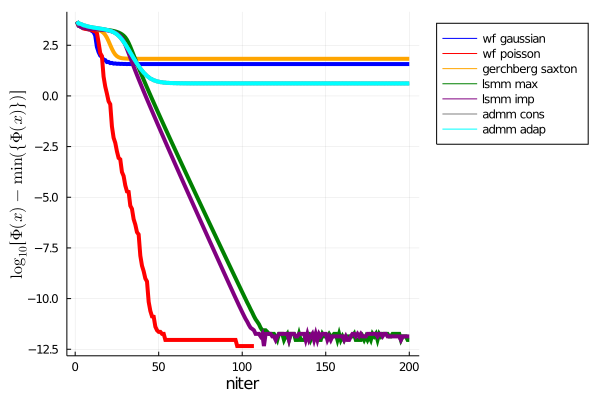

In [7]:
min_cost = minimum([cost_wf_gau; cost_wf_pois; cost_gs; cost_lsmm_max; cost_lsmm_imp; cost_admm_cons; cost_admm_adap])
plot(log10.(cost_wf_gau[1:niter-50] .- min_cost), color=:blue, linewidth = 4, legend=:outertopright, label = "wf gaussian", xlabel = "niter", ylabel = L"\log_{10} [ \Phi(x)-\min(\{\Phi(x)\}) ] ")
plot!(log10.(cost_wf_pois[1:niter-50] .- min_cost), color=:red, linewidth = 4, label = "wf poisson")
plot!(log10.(cost_gs[1:niter-50] .- min_cost), color=:orange, linewidth = 4, label = "gerchberg saxton")
plot!(log10.(cost_lsmm_max[1:niter-50] .- min_cost), color=:green, linewidth = 4, label = "lsmm max")
plot!(log10.(cost_lsmm_imp[1:niter-50] .- min_cost), color=:purple, linewidth = 4, label = "lsmm imp")
plot!(log10.(cost_admm_cons[1:niter-50] .- min_cost), color=:gray, linewidth = 4, label = "admm cons")
plot!(log10.(cost_admm_adap[1:niter-50] .- min_cost), color=:cyan, linewidth = 4, label = "admm adap")


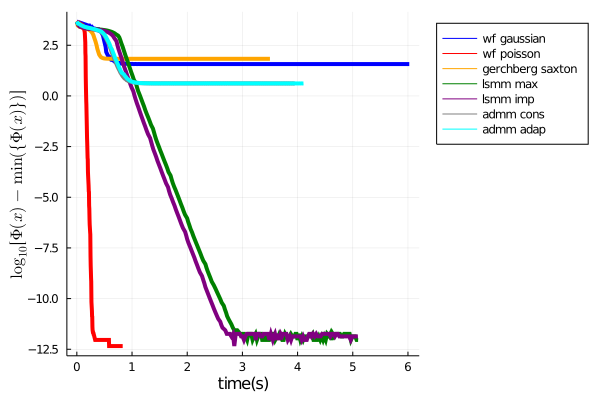

In [8]:
min_cost = minimum([cost_wf_gau; cost_wf_pois; cost_gs; cost_lsmm_max; cost_lsmm_imp; cost_admm_cons; cost_admm_adap])
plot(time_wf_gau[1:niter-50], log10.(cost_wf_gau[1:niter-50] .- min_cost), color=:blue, linewidth = 4, legend=:outertopright, label = "wf gaussian", xlabel = "time(s)", ylabel = L"\log_{10} [ \Phi(x)-\min(\{\Phi(x)\}) ] ")
plot!(time_wf_pois[1:niter-50], log10.(cost_wf_pois[1:niter-50] .- min_cost), color=:red, linewidth = 4, label = "wf poisson")
plot!(time_gs[1:niter-50], log10.(cost_gs[1:niter-50] .- min_cost), color=:orange, linewidth = 4, label = "gerchberg saxton")
plot!(time_lsmm_max[1:niter-50], log10.(cost_lsmm_max[1:niter-50] .- min_cost), color=:green, linewidth = 4, label = "lsmm max")
plot!(time_lsmm_imp[1:niter-50], log10.(cost_lsmm_imp[1:niter-50] .- min_cost), color=:purple, linewidth = 4, label = "lsmm imp")
plot!(time_admm_cons[1:niter-50], log10.(cost_admm_cons[1:niter-50] .- min_cost), color=:gray, linewidth = 4, label = "admm cons")
plot!(time_admm_adap[1:niter-50], log10.(cost_admm_adap[1:niter-50] .- min_cost), color=:cyan, linewidth = 4, label = "admm adap")




In [9]:
xtrue = (cumsum(mod.(1:N, 30) .== 0) .- 1.5) + im * (cumsum(mod.(1:N, 10) .== 0) .- 4.5)
x0_rand = sqrt(var/2) * (randn(N) + im * randn(N))

nrmse_xout_wf_gau = zeros(r_time, length(M_list))
nrmse_xout_wf_pois = zeros(r_time, length(M_list))
nrmse_xout_gs = zeros(r_time, length(M_list))
nrmse_xout_lsmm_max = zeros(r_time, length(M_list))
nrmse_xout_lsmm_imp = zeros(r_time, length(M_list))
nrmse_xout_admm_cons = zeros(r_time, length(M_list))
nrmse_xout_admm_adap = zeros(r_time, length(M_list))


# over sample case
for j = 1:length(M_list)
    M = M_list[j]
    b = 1 * ones(M) # background counts
    for r = 1:r_time
        # Initialize by random vectors
        x0_rand = randn(N)
        A = sqrt(var/2) * (randn(M, N) + im * randn(M, N)) # Each iteration, A is different.
        cons = avg_count / mean(abs2.(A * xtrue))
        A = sqrt(cons) * A # scale matrix A
    #     print("Average counts after scaling: ", mean(abs2.(A * xtrue)))
        y_true = abs2.(A * xtrue) .+ b
        y_pos = rand.(Poisson.(y_true)); # poisson noise
        phi = (v, yi, bi) -> (abs2(v) + bi) - yi * log(abs2(v) + bi) # (v^2 + b) - yi * log(v^2 + b)
        cost_func = (x,iter) -> sum(phi.(A * x, y_pos, b))
    
        xout_wf_gau, cost_wf_gau = Wirtinger_flow(A,y_pos,b; gradhow = :gaussian, xhow = :complex, x0 = x0_rand, niter = niter, fun = cost_func)
        xout_wf_pois, cost_wf_pois = Wirtinger_flow(A,y_pos,b; gradhow = :poisson, xhow = :complex, x0 = x0_rand, niter = niter, fun = cost_func)
        xout_gs, cost_gs = Gerchberg_saxton(A,y_pos,b; xhow = :complex, x0 = x0_rand, niter = niter, fun = cost_func)
        xout_lsmm_max, cost_lsmm_max = LSMM(A,y_pos,b; curvhow = :max, xhow = :complex, x0 = x0_rand, niter = niter, fun = cost_func)
        xout_lsmm_imp, cost_lsmm_imp = LSMM(A,y_pos,b; curvhow = :imp, xhow = :complex, x0 = x0_rand, niter = niter, fun = cost_func)
        xout_admm_cons, cost_admm_cons = poisson_admm_bn0(A,y_pos,b; phow =:constant, xhow = :complex, x0 = x0_rand, ρ = 4, niter = niter, fun = cost_func)
        xout_admm_adap, cost_admm_adap = poisson_admm_bn0(A,y_pos,b; phow =:adaptive, xhow = :complex, x0 = x0_rand, ρ = 4, niter = niter, fun = cost_func)

        # for phase ambiguity
        phase_shift_wf_gau = xtrue' * xout_wf_gau / abs(xtrue' * xout_wf_gau)
        phase_shift_wf_pois = xtrue' * xout_wf_pois / abs(xtrue' * xout_wf_pois)
        phase_shift_gs = xtrue' * xout_gs / abs(xtrue' * xout_gs)
        phase_shift_lsmm_max = xtrue' * xout_lsmm_max / abs(xtrue' * xout_lsmm_max)
        phase_shift_lsmm_imp = xtrue' * xout_lsmm_imp / abs(xtrue' * xout_lsmm_imp)
        phase_shift_admm_cons = xtrue' * xout_admm_cons / abs(xtrue' * xout_admm_cons)
        phase_shift_admm_adap = xtrue' * xout_admm_adap / abs(xtrue' * xout_admm_adap)
        
        nrmse_xout_wf_gau[r,j] = norm(xout_wf_gau - xtrue .* phase_shift_wf_gau) / norm(xtrue .* phase_shift_wf_gau)
        nrmse_xout_wf_pois[r,j] = norm(xout_wf_pois - xtrue .* phase_shift_wf_pois) / norm(xtrue .* phase_shift_wf_pois)
        nrmse_xout_gs[r,j] = norm(xout_gs - xtrue .* phase_shift_gs) / norm(xtrue .* phase_shift_gs)
        nrmse_xout_lsmm_max[r,j] = norm(xout_lsmm_max - xtrue .* phase_shift_lsmm_max) / norm(xtrue .* phase_shift_lsmm_max)
        nrmse_xout_lsmm_imp[r,j] = norm(xout_lsmm_imp - xtrue .* phase_shift_lsmm_imp) / norm(xtrue .* phase_shift_lsmm_imp)
        nrmse_xout_admm_cons[r,j] = norm(xout_admm_cons - xtrue .* phase_shift_admm_cons) / norm(xtrue .* phase_shift_admm_cons)
        nrmse_xout_admm_adap[r,j] = norm(xout_admm_adap - xtrue .* phase_shift_admm_adap) / norm(xtrue .* phase_shift_admm_adap)
        
    end
end
# For real random x0
nrmse_xout_wf_gau = round.(dropdims(mean(nrmse_xout_wf_gau, dims = 1),dims=1);digits = 3)
nrmse_xout_wf_pois = round.(dropdims(mean(nrmse_xout_wf_pois, dims = 1),dims=1);digits = 3)
nrmse_xout_gs = round.(dropdims(mean(nrmse_xout_gs, dims = 1),dims=1);digits = 3)
nrmse_xout_lsmm_max = round.(dropdims(mean(nrmse_xout_lsmm_max, dims = 1),dims=1);digits = 3)
nrmse_xout_lsmm_imp = round.(dropdims(mean(nrmse_xout_lsmm_imp, dims = 1),dims=1);digits = 3)
nrmse_xout_admm_cons = round.(dropdims(mean(nrmse_xout_admm_cons, dims = 1),dims=1);digits = 3)
nrmse_xout_admm_adap = round.(dropdims(mean(nrmse_xout_admm_adap, dims = 1),dims=1);digits = 3)

@show nrmse_xout_wf_gau
@show nrmse_xout_wf_pois
@show nrmse_xout_gs
@show nrmse_xout_lsmm_max
@show nrmse_xout_lsmm_imp
@show nrmse_xout_admm_cons
@show nrmse_xout_admm_adap





nrmse_xout_wf_gau = [0.43, 0.261, 0.212, 0.185, 0.166, 0.158]
nrmse_xout_wf_pois = [0.388, 0.229, 0.182, 0.154, 0.144, 0.128]
nrmse_xout_gs = [0.417, 0.24, 0.204, 0.179, 0.172, 0.155]
nrmse_xout_lsmm_max = [0.389, 0.229, 0.182, 0.154, 0.144, 0.128]
nrmse_xout_lsmm_imp = [0.389, 0.229, 0.182, 0.154, 0.144, 0.128]
nrmse_xout_admm_cons = [0.385, 0.233, 0.186, 0.156, 0.146, 0.132]
nrmse_xout_admm_adap = [0.385, 0.233, 0.186, 0.156, 0.146, 0.132]


6-element Array{Float64,1}:
 0.385
 0.233
 0.186
 0.156
 0.146
 0.132